# Imports

Standard Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams["figure.figsize"] = (15, 11)
# Change the default plot theming
from jupyterthemes import jtplot
jtplot.style(theme="default")

Scatmm Related imports

In [2]:
# Import the Database class to interact with the stored data
from Database.database import Database
# Layer management - Layer1D (non-dispersive materials)/Layer3D (dispersive materials)
from modules.s_matrix import Layer1D, Layer3D
# Import the functions responsible for the calculations
from modules.s_matrix import smm_broadband, smm, smm_layer, smm_angle
# Default dictionary with simulation configuration
from modules.s_matrix import sim_config

# See Documentation

Documentation for the functions - use ?

In [4]:
?Layer1D

Init signature: Layer1D(name: str, thickness: float, n_val: float, k_val: float) -> None
Docstring:     
Layer for single wavelength materials
Args:
    name (str): Identifier for the layer
    thickness (float - nm): Layer thickness
    lmb (nm)/n_val/k_val (array): Material info for the layer
File:           ~/Documents/Python/Scattering Matrix Method/Scatmm/modules/s_matrix.py
Type:           type
Subclasses:     


In [5]:
?Layer3D

Init signature:
Layer3D(
    name: str,
    thickness: float,
    lmb: numpy.ndarray,
    n_array: numpy.ndarray,
    k_array: numpy.ndarray,
    **kwargs,
) -> None
Docstring:     
Layer for single wavelength materials
Args:
    name (str): Identifier for the layer
    thickness (float - nm): Layer thickness
    lmb (nm)/n_array/k_array (array): Arrays with the
                                      basic info for each layer
    **kwargs: Pass extra arguments for interpolation function
File:           ~/Documents/Python/Scattering Matrix Method/Scatmm/modules/s_matrix.py
Type:           type
Subclasses:     


In [6]:
?smm_broadband

Signature:
smm_broadband(
    layer_list: List[Union[modules.s_matrix.Layer1D, modules.s_matrix.Layer3D]],
    theta: float,
    phi: float,
    lmb: numpy.ndarray,
    pol: Tuple[complex, complex],
    i_med: Tuple[complex, complex],
    t_med: Tuple[complex, complex],
    override_thick=None,
) -> Tuple[numpy.ndarray, numpy.ndarray]
Docstring:
SMM for broadband simulation
Args:
    layer_list: List of Layer objects with the info for all layers
    theta/phi: Incidence angles
    lmb: Array with wavelengths for simulation
    pol: Tuple with the TM/TE polarization components
    i_med/t_med: Data for the reflection and transmission media
    override_thick: Override the built thickness of the layers
Returns:
    R, T: Arrays with the Reflection and transmission for the layer setup
File:      ~/Documents/Python/Scattering Matrix Method/Scatmm/modules/s_matrix.py
Type:      function


# Simulations

The module comes with a default _sim_config_ dictionary structure with some default values

__Notes__:
* The default config should work for smm
* For smm_angle/smm_broadband/smm_layer the respective changing variables should be set (theta and lmb)

In [7]:
# Default simulation configuration (only works with smm)
print(sim_config)

{'theta': 0.0, 'phi': 0.0, 'lmb': 500.0, 'pol': (1, 0), 'i_med': (1, 1), 't_med': (1, 1)}


## Simulation - Single Wavelength (500 nm)

Layer Structure:
Ref (e=1, u=1)|Layer1 (n=1.5, k=0, 250 nm)|Layer2 (n=1.7, k=0.1, 300 nm)|Trn (e=1, u=1)|

In [3]:
# First define the various layers
Layer1 = Layer1D("Layer1", 250, 1.5, 0)
Layer2 = Layer1D("Layer2", 300, 1.7, 0.1)
# Create a dictionary with the remaining simulation values
smm([Layer1, Layer2], **sim_config)

1.0 1.0 [1.+0.j 0.+0.j]


(0.06249987221201086, 0.41650507396657144)

Changing input angle (the angle should be in radians)

In [4]:
# override theta in sim_config
# When changing values in the config is better to copy to a new variable
new_config = sim_config.copy()
new_config["theta"] = np.radians(50) # 50º angle
smm([Layer1, Layer2], **new_config)

0.6427876096865394 0.6427876096865394 [0.64278761+0.j 0.        +0.j]


(8.05281464351907e-06, 0.42832852454855935)

## Simulation Broadband - 300-900 nm

Layer Structue: Ref(e=1, u=1)|L1: AZO(150 nm)|L2: aSi(300 nm)|L3:Al(120 nm)|Trn(e=1, u=1)

In [5]:
# Get the data from the database file
db = Database("Database/database")
# Get Database content
db.content

['aSi Pierce 1972',
 'AZO Treharne 2011',
 'ITO Konig 2014',
 'ZnO Unknown',
 'IZO Ellipsometer',
 'Silicon Green',
 'Al McPeak',
 'Perovskite Phillips',
 'aSi_H Ellipsometer',
 'Ag JC',
 'Perovskite Eerden',
 'TiO2 - Siefke']

In [6]:
# The Database can elements can be acessed in either of 2 ways
# db[0] - with int integer that represent the number of the entry
# db["aSi Pierce 1972"] - with the string defining the name of the material
# The data is provided as (wavelength - nm/n/k)
np.all(db[0] == db["aSi Pierce 1972"])

True

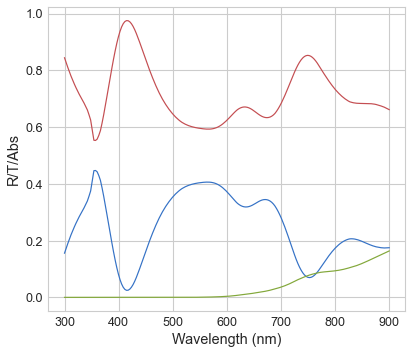

In [7]:
# Create the layers - for this case we need the 2/1/7 entries of the database
azo_data = db["AZO Treharne 2011"]
Layer1 = Layer3D("AZO", 150, azo_data[:, 0], azo_data[:, 1], azo_data[:, 2])
si_data = db["aSi Pierce 1972"]
Layer2 = Layer3D("aSi", 300, si_data[:, 0], si_data[:, 1], si_data[:, 2])
al_data = db["Al McPeak"]
Layer3 = Layer3D("Al", 120, al_data[:, 0], al_data[:, 1], al_data[:, 2])
# Override sim_config lmb
broadband_config = sim_config.copy()
lmb = np.linspace(300, 900, 200)
broadband_config["lmb"] = lmb
# Run the calculation
r, t = smm_broadband([Layer1, Layer2, Layer3], **broadband_config)

plt.xlabel("Wavelength (nm)")
plt.ylabel("R/T/Abs")
plt.plot(lmb, r, lmb, t, lmb, 1-r-t);

## Layer Simulations

Calculate the individual layer absorptions for the previous case

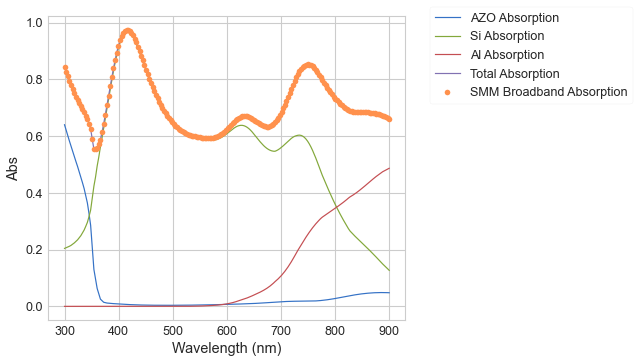

In [12]:
db = Database("Database/database")
# Create the layers - for this case we need the 2/1/7 entries of the database
azo_data = db["AZO Treharne 2011"]
Layer1 = Layer3D("AZO", 150, azo_data[:, 0], azo_data[:, 1], azo_data[:, 2])
si_data = db["aSi Pierce 1972"]
Layer2 = Layer3D("aSi", 300, si_data[:, 0], si_data[:, 1], si_data[:, 2])
al_data = db["Al McPeak"]
Layer3 = Layer3D("Al", 120, al_data[:, 0], al_data[:, 1], al_data[:, 2])
# Override sim_config lmb
broadband_config = sim_config.copy()
lmb = np.linspace(300, 900, 200)
broadband_config["lmb"] = lmb
# Add the variable layer_i="layer" to choose the layer to calculate the absorption
abs_azo = smm_layer([Layer1, Layer2, Layer3], layer_i=1, **broadband_config)
abs_si = smm_layer([Layer1, Layer2, Layer3], layer_i=2, **broadband_config)
abs_al = smm_layer([Layer1, Layer2, Layer3], layer_i=3, **broadband_config)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Abs")
plt.plot(lmb, abs_azo, label="AZO Absorption")
plt.plot(lmb, abs_si, label="Si Absorption")
plt.plot(lmb, abs_al, label="Al Absorption")
plt.plot(lmb, abs_si+abs_azo+abs_al, label="Total Absorption")
plt.plot(lmb, 1-r-t, "o", label="SMM Broadband Absorption")
plt.legend(bbox_to_anchor=(1.05, 1.05))